# 0. Introduction

Aside from travel times to a prescribed destination, we might also wonder how the introduction of the metro might impact the 'general' mobility of individuals, their capacity to 'get around.' **Spatial outreach** is a measure of this capacity. We define the spatial outreach of a node in a network as follows: 

Let $\ell(i,j)$ be the length of the shortest path between node $i$ and node $j$ measured according to some chosen edge weights. We define the set $S(r) = \{j \; | \; \ell(i,j) < r  \}$ as the set of nodes reachable from $i$ for prescribed cost $r$. Let $P(r)$ be the convex hull of $S(r)$, and $A(r)$ the area of $P(r)$. The **spatial outreach** of node $i$ for cost $r$ is then $\sqrt{A(r)}$. As defined, spatial outreach has units of length, and is a measure of the radius of the convex hull of $S(r)$.

In this analysis, we'll investigate three primary questions: 

1. How does the introduction of a metro impact 'average' or 'global' spatial outreach?
2. How is spatial outreach distributed throughout the city, and how does the introduction of the metro affect this distribution?
3. How does the introduction of a metro 'look' in terms of the accessibility of individuals? 

## 0.1 Assumptions

- All computations involving edge weights on the street use congested travel time (in minutes) as determined through ITA. 
- All computations involving edge weights on the metro network use free-flow travel time. The metro network is uncapacitated. 
- No waiting times are modeled from street to metro or back: agents pick up the metro as soon as they arrive. 

In [1]:
import matplotlib
matplotlib.use('Agg')

% matplotlib inline

# homebrewed modules
from metro import multiplex as mx
from metro import io            # for reading multiplex
from metro import utility       # for manipulating multiplex
from metro import analysis      # analytical functions
from metro import viz           # for bubble_plot()
from metro import assignment    # for reading and manipulating OD data

# other modules
import warnings                 # suppress ipython warnings
import networkx as nx           # assigning attributes to multiplex
import random                   # randomly sample node subsets
import matplotlib.pyplot as plt # convenience for plotting
import seaborn as sns           # main plotting library
from matplotlib import pylab    # for colormap manipulation
import numpy as np              # math functions

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
warnings.filterwarnings('ignore') # stops ipython from printing warnings
sns.set_style("white") # nicer background style

In [3]:
multi = mx.read_multi(nodes_file_name = '3_throughput/mx_flow_nodes.txt', 
                      edges_file_name = '3_throughput/mx_flow_edges.txt')

In [4]:
multi.read_od(layer = 'taz', # keys are in this layer
          key = 'taz', # this is the key attribute
          od_file = '1_data/taz_od/0_1.txt', # here's where the file lives
          sep = ' ') # this is what separates entries

In [5]:
origin_demand = {o : sum(multi.od[o].values()) for o in multi.od}

In [6]:
betas = [1, .9, 0.5, 0.1, .01] # metro speeds we'll analyse, .5 means metro runs twice as fast

analysis.spatial_outreach(multi, 
                          node_layer = 'taz', # compute at these nodes
                          thru_layers = ['streets', 'metro'], # travel is allowed through this layer -- no metro
                          weight = 'congested_time_m_100',
                          cost = 20,
                          attrname = 'outreach_no_metro')

for beta in betas: 
    analysis.spatial_outreach(multi, 
                          node_layer = 'taz', # compute at these nodes
                          thru_layers = ['streets', 'metro'], # travel is allowed through this layer -- no metro
                          weight = 'congested_time_m_' + str(beta),
                          cost = 20,
                          attrname = 'outreach_' + str(beta))

In [7]:
attrs = ['outreach_no_metro'] + ['outreach_' + str(beta) for beta in betas]
# attrs = ['outreach_' + str(beta) for beta in betas]
df = multi.nodes_2_df(layers = 'taz', attrs = attrs)
df.head()

df['o_demand'] = df.label.map(origin_demand.get)

# df = df[~np.isnan(df.outreach_0.01)]



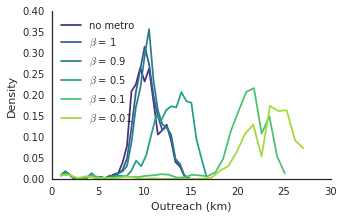

In [8]:
reload(viz)
sns.set_palette('viridis')
for col in ['o_demand', 'outreach_no_metro'] + ['outreach_' + str(beta) for beta in betas]:
    df = df[~np.isnan(df[col])]
    
fig = plt.figure(figsize = (5,3))
ax = fig.add_subplot(111)
viz.weighted_hist(ax = ax, 
                  measure = df.outreach_no_metro,
                  weights = df.o_demand,
                  label = 'no metro',
                  standardized = False,
                  n = 30)
for beta in betas:
    viz.weighted_hist(ax = ax, 
                  measure = df['outreach_' + str(beta)],
                  weights = df.o_demand,
                  label = r'$\beta$ = ' + str(beta),
                  standardized = False,
                  n = 30)
ax.legend(loc = 2)
ax.set(xlabel = 'Outreach (km)', ylabel = 'Density')
sns.despine()
plt.savefig('4_figs/outreach_distributions.png')

In [9]:
for col in ['outreach_no_metro'] + ['outreach_' + str(beta) for beta in betas]:
    print np.average(df[col], weights = df.o_demand), analysis.gini_coeff(df[col])

10.2917891727 0.0870894820795
10.4734714525 0.0792212066044
10.6133151773 0.0750955270151
12.9126617865 0.0816512600317
20.5887640394 0.0719290896032
23.1577894156 0.0672644321503


In [11]:
df.head()

,label,layer,outreach_0.01,outreach_0.1,outreach_0.5,outreach_0.9,outreach_1,outreach_no_metro,o_demand
0,taz_10273,taz,24.529641,21.594241,13.866234,11.853870,11.853870,11.853870,761.962500
1,taz_10272,taz,26.047242,23.150812,13.991066,10.119469,9.632901,9.540720,343.516667
2,taz_10271,taz,24.542696,22.486787,14.081299,12.452292,12.452292,12.439223,761.962500
3,taz_10270,taz,26.047242,23.568891,14.940315,10.394381,10.219842,9.955128,72.130000
4,taz_10277,taz,24.955182,21.661602,12.613548,11.965614,11.965614,11.965614,230.017500


# 2. Spatial distribution of outreach

We would expect that the introduction of a metro would have the most impact on spatial outreach for those who live near it. To test this expectation, we plot the outreach at each TAZ node for no metro and for $\beta \in \{1.0, 0.5, 0.1\}$. The size of each bubble is proportional to the estimated population. Cooler colors reflect lower spatial outreach, while warmer colors reflect higher outreach. 

In [16]:
# pop = {df['id'][i] : df['flow_norm'][i] for i in df.index}
for col in df:
    if col != 'label':
        d = {df['label'][i] : df[col][i] for i in df.index}
        nx.set_node_attributes(multi.G, col, 0)
        nx.set_node_attributes(multi.G, col, d)

## Observations

- Baseline outreach appears to be highest for the population living toward the northwest of the city. PC conjectures that this is due to proximity to multiple highways, but further investigation is called for. 
- The introduction of a metro does not begin to noticeably increase spatial outreach until we significantly increase metro speeds (see plot for $\beta = 0.5$).
- As the metro speed increases, we begin to see very high outreach at nodes very close to the metro; indeed, the dark red in the rightmost diagram closely traces the metro network. 
- As we saw above, there are a small number of nodes that are more than 20 minutes away from any metro line. These nodes remain dark blue throughout all four plots.
- This plot is roughly comparable to Strano et al.'s Fig. 4(a-d)

# 3. Visualizing individual outreach

As another exploratory measure, we can also observe how the mobility of an individual increases with metro speed.  

In [18]:
# utility function: plots a network with a prescribed color
def plot_ego(ego, color):
    ego.position = {n : (ego.node[n]['lon'], ego.node[n]['lat']) for n in ego}
    nx.draw(ego, ego.position,
    edge_color = color, 
    edge_size = 20,
    node_color = color,
    linewidth = 0,
    node_size = 0,
    alpha = .3,
    with_labels = False,
    arrows = False)

# utility function: converts an RGB-tuple returned by a colormap into a hex format readable by plot_ego()
def RGBToHTMLColor(rgb_tuple):
    """ convert an (R, G, B) tuple to #RRGGBB """
    hexcolor = '#%02x%02x%02x' % rgb_tuple
    return hexcolor

The below plot reflects the spatial outreach of an individual located at a random node on the network, indicated by the white dot. Lighter colors indicate more easily accessible nodes; darker reds indicate less accessible nodes. The individual's maximum travel time is 30 minutes. 

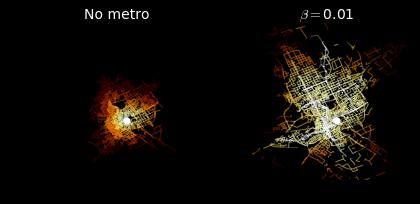

In [ ]:
pylab.rcParams['savefig.facecolor'] = 'black'

betas = [100, .01] # metro speeds we'll analyse, .5 means metro runs twice as fast

G = multi.as_graph()

node = random.choice(G.node.keys()) # pick a random node at which to start

fig = plt.figure(figsize = (len(betas) * 3,3)) # initialize empty figure

i = 1 # keeps track of which subplot we are on
for beta in betas: 
    ax = fig.add_subplot(1,len(betas),i)   
    i += 1
    
    # scale metro speed
    
    total = nx.DiGraph() # nodes we've already seen
    radii = [5, 10, 15, 20, 25, 30]
    
    for radius in radii: # main plotting loop
        
        # get a color from a colormap for this layer of the plot
        x = pylab.cm.afmhot(1 - (radius*1.0 - min(radii)) / max(radii)) 
        x = tuple([y * 255 for y in list(x)])
        
        # compute the ego graph for this radius and remove nodes we've already seen
        ego = nx.ego_graph(G, node, radius = radius, distance = 'congested_time_m_' + str(beta))
        ego.remove_nodes_from(n for n in ego.copy() if n in total) # remove from ego all the nodes we've already seen
        total = nx.union(total, ego) # seen them now
        
        # plot resulting slice of the ego graph
        plot_ego(ego, RGBToHTMLColor(x[:3]))
        
    plt.plot(G.node[node]['lon'], G.node[node]['lat'], 'wo') # plot the starting node
    if beta == 100:
        title = 'No metro'
    else:
        title = r'$\beta = $' + str(beta) 
    plt.title(title, 
              color = 'w', 
              fontsize = 14)    # aesthetics: 
    xlim = (46.4167, 47.0167)
    ylim = (24.4333, 25.0333)
    ax = plt.gca() # get current axis to set lims
    ax.set(xlim = xlim, ylim = ylim)
    fig.set_facecolor("#000000") # black backgrounds are cool, like bowties
    plt.tight_layout()
    plt.savefig('4_figs/individual_outreach.png')

We observe that the individual's mobility substantially increases as $\beta$ decreases. Though initially the metro plays relatively little role in the individual's mobility, as $\beta$ crosses $0.5$ we begin to observe the contours of the reachable set structured around the metro lines. 

# 4. Wrapping up

Spatial outreach is a measure of individual mobility in the multiplex. In this analysis, we have learned the following: 

1. Spatial outreach is heterogeneously distributed throughout the Riyadh network. 
2. The introduction of the metro at base speed has relatively little impact on spatial outreach. 
3. Speeding up the metro by decreasing $\beta$ increases average spatial outreach at most nodes, and results in concentrations of very high outreach around metro stops. 
4. Some nodes are so far away from the metro that decreases in $\beta$ are irrelevant for their outreach, at least at a radius of 20 minutes. 